Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (be

Discrete Evolution Model Posterior Summary:
                 mean     sd  hdi_10%  hdi_90%  mcse_mean  mcse_sd  ess_bulk  \
alpha_imbal[0]  0.011  1.003   -1.195    1.347      0.014    0.016    4919.0   
alpha_imbal[1] -0.017  1.005   -1.188    1.377      0.015    0.016    4702.0   
alpha_imbal[2] -0.012  0.985   -1.262    1.227      0.013    0.017    5592.0   
alpha_imbal[3]  0.007  0.993   -1.350    1.199      0.014    0.015    5338.0   
alpha_prev[0]  -0.743  0.718   -1.654    0.099      0.011    0.009    4638.0   
alpha_prev[1]   0.367  0.842   -0.697    1.419      0.012    0.014    5227.0   
alpha_prev[2]   0.592  0.920   -0.563    1.827      0.013    0.012    5247.0   
alpha_prev[3]   0.017  0.699   -0.840    0.861      0.010    0.012    4532.0   
imbalance[0]    0.011  1.003   -1.195    1.347      0.014    0.016    4919.0   
imbalance[1]    0.000  0.000    0.000    0.000      0.000    0.000    4000.0   
imbalance[2]    0.000  0.000    0.000    0.000      0.000    0.000    4000.0

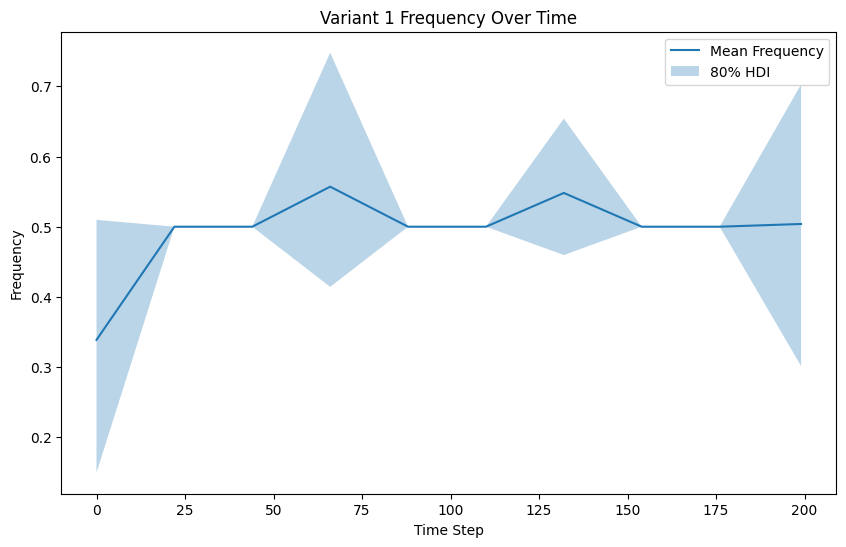

Output()

Output()


Social Dynamics Model Posterior Summary:
                        mean     sd  hdi_10%  hdi_90%  mcse_mean  mcse_sd  \
age_effect[0]         -0.357  0.380   -0.830    0.156      0.008    0.006   
age_effect[1]         -0.292  0.380   -0.791    0.178      0.009    0.007   
age_effect[2]          0.265  0.465   -0.389    0.796      0.013    0.009   
age_effect[3]         -0.068  0.592   -0.774    0.742      0.017    0.012   
age_effect[4]          0.046  0.753   -0.996    0.911      0.023    0.017   
init_prev              0.451  0.277    0.001    0.728      0.007    0.005   
social_effect         -0.174  0.206   -0.435    0.090      0.006    0.005   
variant_prevalence[0]  0.523  0.070    0.436    0.614      0.001    0.001   
variant_prevalence[1]  0.496  0.070    0.403    0.584      0.001    0.001   
variant_prevalence[2]  0.589  0.069    0.497    0.675      0.001    0.001   
variant_prevalence[3]  0.466  0.070    0.380    0.558      0.001    0.001   
variant_prevalence[4]  0.452  0.07

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
import pymc as pm
import arviz as az

# Part 1: Discrete Evolution Model with Inference
class DiscreteEvolutionModel:
    def __init__(self, data):
        self.data = data
        self.time_steps = data['X'].values
        self.frequencies = data['A'].values

    def create_inference_model(self):
        with pm.Model() as model:
            # Spline knots and basis
            n_knots = 4
            knots = np.linspace(self.time_steps.min(), self.time_steps.max(), n_knots)

            # Spline basis for prevalence
            B_prev = self._create_spline_basis(self.time_steps, knots)

            # Spline basis for imbalance
            B_imbal = self._create_spline_basis(self.time_steps, knots)

            # Priors for spline coefficients
            alpha_prev = pm.Normal('alpha_prev', mu=0, sigma=1, shape=n_knots)
            alpha_imbal = pm.Normal('alpha_imbal', mu=0, sigma=1, shape=n_knots)

            # Compute prevalence and imbalance through splines
            prevalence = pm.Deterministic('prevalence', pm.math.sigmoid(pm.math.dot(B_prev, alpha_prev)))
            imbalance = pm.Deterministic('imbalance', pm.math.dot(B_imbal, alpha_imbal))

            # Likelihood
            sigma = pm.HalfNormal('sigma', sigma=0.1)
            likelihood = pm.Normal('likelihood',
                                   mu=prevalence,
                                   sigma=sigma,
                                   observed=self.frequencies)

        return model

    def _create_spline_basis(self, x, knots):
        basis = np.zeros((len(x), len(knots)))
        for i, k in enumerate(knots):
            basis[:, i] = np.maximum(0, 1 - np.abs(x - k))
        return basis

    def run_inference(self, draws=2000, tune=1000):
        model = self.create_inference_model()
        with model:
            trace = pm.sample(draws=draws, tune=tune)
        return trace

    def posterior_summary(self, trace):
        summary = az.summary(trace, hdi_prob=0.8)
        return summary

    def plot_posterior_frequency(self, trace):
        # Extract prevalence data correctly from the trace
        prevalence = trace.posterior['prevalence'].values

        # Calculate mean and HDI
        mean_freq = np.mean(prevalence, axis=(0, 1))
        hdi = az.hdi(prevalence, hdi_prob=0.8)

        plt.figure(figsize=(10, 6))
        plt.plot(self.time_steps, mean_freq, label='Mean Frequency')
        plt.fill_between(self.time_steps, hdi[..., 0], hdi[..., 1], alpha=0.3, label='80% HDI')
        plt.title('Variant 1 Frequency Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

# Part 2: Social Dynamics Model
class SocialDynamicsModel:
    def __init__(self, age_groups, initial_prev=0.1):
        self.age_groups = age_groups
        self.initial_prev = initial_prev

        # Final distribution from the assignment
        self.final_distribution = {
            '75+': {'Variant 1': 0.25, 'Variant 2': 0.22},
            '61-75': {'Variant 1': 0.35, 'Variant 2': 0.37},
            '46-60': {'Variant 1': 0.62, 'Variant 2': 0.44},
            '31-45': {'Variant 1': 0.81, 'Variant 2': 0.88},
            '14-30': {'Variant 1': 0.37, 'Variant 2': 0.46}
        }

    def create_inference_model(self):
        with pm.Model() as model:
            # Infer initial prevalence
            init_prev = pm.Uniform('init_prev', lower=0, upper=1)

            # Social dynamics parameters
            social_effect = pm.Normal('social_effect', mu=0, sigma=1)
            age_effect = pm.Normal('age_effect', mu=0, sigma=1, shape=len(self.age_groups))

            # Simulate variants for each age group
            variant_prevalence = pm.Deterministic('variant_prevalence',
                                                  pm.math.sigmoid(
                                                      init_prev +
                                                      social_effect * np.arange(len(self.age_groups)) +
                                                      age_effect
                                                  ))

            # Likelihood based on final distribution
            for idx, (age_group, distributions) in enumerate(self.final_distribution.items()):
                v1_obs = pm.Normal(f'v1_{age_group}',
                                   mu=variant_prevalence[idx],
                                   sigma=0.1,
                                   observed=distributions['Variant 1'])
                v2_obs = pm.Normal(f'v2_{age_group}',
                                   mu=1 - variant_prevalence[idx],
                                   sigma=0.1,
                                   observed=distributions['Variant 2'])

        return model

    def run_inference(self, draws=2000, tune=1000):
        model = self.create_inference_model()
        with model:
            trace = pm.sample(draws=draws, tune=tune)
        return trace

    def plot_variant_prevalence(self, trace):
        variant_prevalence = trace.posterior['variant_prevalence'].values

        # Calculate mean and HDI
        mean_prev = np.mean(variant_prevalence, axis=(0, 1))
        hdi = az.hdi(variant_prevalence, hdi_prob=0.8)

        plt.figure(figsize=(10, 6))
        plt.bar(self.age_groups, mean_prev, yerr=(mean_prev - hdi[..., 0], hdi[..., 1] - mean_prev),
                capsize=5, alpha=0.7)
        plt.title('Variant Prevalence Across Age Groups')
        plt.xlabel('Age Group')
        plt.ylabel('Prevalence')
        plt.ylim(0, 1)
        plt.show()

def main():
    # Part 1: Discrete Evolution Model
    try:
        # Load data
        data = pd.read_csv('section1_data1.csv')

        # Initialize and run Discrete Evolution Model
        dev_model = DiscreteEvolutionModel(data)
        trace_dev = dev_model.run_inference()

        # Posterior summary and plotting
        summary_dev = dev_model.posterior_summary(trace_dev)
        print("Discrete Evolution Model Posterior Summary:")
        print(summary_dev)
        dev_model.plot_posterior_frequency(trace_dev)
    except FileNotFoundError:
        print("Error: section1_data1.csv not found. Please ensure the file is in the correct directory.")
    except Exception as e:
        print(f"An error occurred in Discrete Evolution Model: {e}")

    # Part 2: Social Dynamics Model
    try:
        age_groups = ['14-30', '31-45', '46-60', '61-75', '75+']
        soc_model = SocialDynamicsModel(age_groups)
        trace_soc = soc_model.run_inference()

        # Posterior summary for Social Dynamics Model
        summary_soc = az.summary(trace_soc, hdi_prob=0.8)
        print("\nSocial Dynamics Model Posterior Summary:")
        print(summary_soc)
    except Exception as e:
        print(f"An error occurred in Social Dynamics Model: {e}")

if __name__ == '__main__':
    main()